In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo


In [2]:
#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

In [149]:
len(lofar_opt)

2105220

In [157]:
np.sum(lofar_rad['FLAG_WORKFLOW']==5)

898

In [156]:
lofar_rad.colnames

['Source_id',
 'Isl_id',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'RA_max',
 'E_RA_max',
 'DEC_max',
 'E_DEC_max',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Maj_img_plane',
 'E_Maj_img_plane',
 'Min_img_plane',
 'E_Min_img_plane',
 'PA_img_plane',
 'E_PA_img_plane',
 'DC_Maj',
 'E_DC_Maj',
 'DC_Min',
 'E_DC_Min',
 'DC_PA',
 'E_DC_PA',
 'DC_Maj_img_plane',
 'E_DC_Maj_img_plane',
 'DC_Min_img_plane',
 'E_DC_Min_img_plane',
 'DC_PA_img_plane',
 'E_DC_PA_img_plane',
 'Isl_Total_flux',
 'E_Isl_Total_flux',
 'Isl_rms',
 'Isl_mean',
 'Resid_Isl_rms',
 'Resid_Isl_mean',
 'S_Code',
 'FLAG_OVERLAP',
 'lr_fin',
 'lr_dist_fin',
 'lr_index_fin',
 'fworkflow_all',
 'FLAG_WORKFLOW']

In [3]:
#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [148]:
len(lofar)

32833

In [4]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'

pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'#SPIRE 500 map

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[2].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[2].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [44]:
# find the position of the radio source
ra = lofar['ra'][[3]]
dec = lofar['dec'][[3]]

#using pyvo find all help objects within 1 arcminute of the rdaio crossmatch
columns = 'ra','dec','help_id','f_spire_250','ferr_spire_250','flag_spire_250','f_spire_350','ferr_spire_350','flag_spire_350','f_spire_500','ferr_spire_500','flag_spire_500','flag_optnir_det','f_mips_24'
query = """
SELECT *
FROM herschelhelp.main AS db
JOIN TAP_UPLOAD.t1 AS tc
ON 1=CONTAINS(POINT('ICRS', db.ra, db.dec),
CIRCLE('ICRS', tc.RA, tc.DEC, 1./60.))
"""

pos = Table()
pos.add_column(Column(data=ra, name='ra'))
pos.add_column(Column(data=dec, name='dec'))

service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")
job = service.submit_job(query,
                          uploads = {'t1': pos})
job.run()
    
while job.phase == "EXECUTING":
    print("Job running")
    sleep(5)
print('job finsihed')
help_all = job.fetch_result().to_table()
help_all['help_id'] = help_all['help_id'].astype(str)
help_all.remove_column('ra_')
help_all.remove_column('dec_')

Job running
job finsihed


In [38]:
help_masterlist = help_all[columns]

#### following cells are for the python version of the code as pyvo doesn't seem to work on apollo2 when submitted to the queue

#comparing with the help masterlist from fits file
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = help_masterlist[columns]

lofar_coords = SkyCoord(ra,dec,unit='deg')
help_coords = SkyCoord(help_masterlist['ra'],help_masterlist['dec'],unit='deg')
radius = 60
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)
help_masterlist = help_masterlist[idx_help]

In [ ]:
#Read in the Ldust prdictions from CIGALE
#when these are on the VO i will change code to read it in from then
ldust = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_ELAIS-N1/data/ELAIS_N1_Ldust_prediction_results.fits') 
ldust.rename_column('id','help_id')
ldust['help_id'] = ldust['help_id'].astype(str)
#join Ldust predictions with the help table
help_masterlist_ldust = join(help_masterlist,ldust,keys='help_id',join_type='inner')

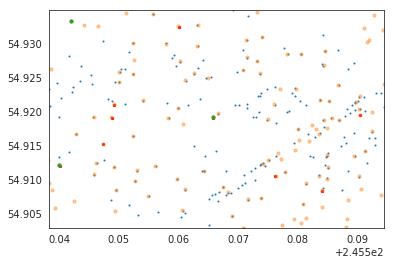

In [118]:
x = help_masterlist['ra']
y = help_masterlist['dec']
plt.scatter(x,y,s=1)

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=5,color='red')

x = lofar_opt['ra']
y = lofar_opt['dec']
plt.scatter(x,y,s=10,alpha=0.4)

x = lofar['ra']
y = lofar['dec']
plt.scatter(x,y,s=10)

plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

In [45]:
#Crossmatch the lofar source with the help masterlist
lofar_coords = SkyCoord(ra,dec,unit='deg')
help_coords = SkyCoord(help_masterlist['ra'],help_masterlist['dec'],unit='deg')
radius = 2
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)

In [58]:
#create the prior list from the help masterlist
prior_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)
prior_mask = prior_mask.data
prior_cat = help_masterlist[prior_mask]
xid_rerun = Column(name='XID_rerun',data=np.zeros(len(prior_cat))-99)
prior_cat.add_column(xid_rerun)

In [60]:
#if there is only one crossmatch within the search radius then match them if the source is in the prior list
#otherwise add the ra and dec of the lofar optical counterpart to the prior list
XID_rerun = []
source_type = []
mask = (help_masterlist[idx_help]['flag_optnir_det']>=5) & (help_masterlist[idx_help]['f_mips_24']>20)
idx_true = idx_help[mask]

if len(d2d) == 0:
    min_d2d = np.nan
else:
    min_d2d = np.min(d2d)

if d2d[mask] != min_d2d:
    source_type.append('nearer_non_prior')
    XID_rerun.append(False)
if np.sum(mask)==0:
    prior_cat.add_row([ra,dec,'lofar',np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,-99,np.nan,False])
    source_type.append('radio_position')
    XID_rerun.append(True)
if np.sum(mask)>1:
    nearer = ''
    if np.min(d2d[mask]) != min_d2d:
        nearer = 'nearer_non_prior'
    for n in range(np.sum(mask)):
        source_type.append('multiple_prior'+nearer)
        XID_rerun.append(False)
if np.sum(mask)==1:
    source_type.append('nearest_prior')
    XID_rerun.append(False)
    if d2d[mask] != np.min(d2d):
        source_type.append('nearer_non_prior')
        XID_rerun.append(False)


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]


In [11]:
if False in XID_rerun:
    mask = lofar['ra']==ra
    lofar_fir = hstack([lofar[mask],help_masterlist[idx_true]])
    XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
    source_type_col = Column(data=source_type,name='source_type',dtype=str)
    lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
    #os.mkdir('testfolder')
    #Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

FileExistsError: [Errno 17] File exists: 'testfolder'

In [ ]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=1)

x = lofar_opt['ra']
y = lofar_opt['dec']
plt.scatter(x,y,s=10,alpha=0.4)

x = lofar['ra']
y = lofar['dec']
plt.scatter(x,y,s=10)

plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

In [107]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ra, dec=dec)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

In [113]:
prior_cat

ra,dec,help_id,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,flag_optnir_det,f_mips_24,XID_rerun
deg,deg,,uJy,uJy,,uJy,uJy,,uJy,uJy,,,uJy,
float64,float64,str27,float64,float64,bool,float64,float64,bool,float64,float64,bool,int16,float64,float64
245.584016880909,54.908235926597,HELP_J162220.164+545429.649,4109.603,3598.0767,False,3471.6656,3868.0771,True,3573.5943,4307.4634,True,6,141.35925,-99.0
245.576239157057,54.9104112294993,HELP_J162218.297+545437.480,14451.437,3233.587,False,23055.286,3068.714,False,20061.289,4085.579,False,7,152.92062,-99.0
245.590419726057,54.9194252704993,HELP_J162221.701+545509.931,8477.818,3083.4303,False,9570.479,3508.034,False,9577.023,4548.372,False,7,122.0679,-99.0
245.565760902989,54.9190265823287,HELP_J162215.783+545508.496,11019.371,3092.1416,False,21895.573,3110.403,False,25246.68,1562.829,False,6,59.862274,-99.0
245.560038092507,54.9323964694815,HELP_J162214.409+545556.627,2783.1938,2564.2002,True,10014.736,2875.889,False,5980.377,3611.049,False,6,84.707504,-99.0
245.547407252057,54.9151292264993,HELP_J162211.378+545454.465,1611.1495,1905.7003,True,1197.6242,1564.112,True,2587.943,2985.5204,True,7,96.49357,-99.0
245.549188716057,54.9209592044993,HELP_J162211.805+545515.453,2982.3341,3024.3599,True,1719.9976,2248.0772,True,3204.255,3464.7966,True,7,129.83755,-99.0
245.548793572057,54.9190348104993,HELP_J162211.710+545508.525,1871.2075,2337.0585,True,1460.541,1872.3505,True,2396.5487,2895.1813,True,7,246.57957,-99.0


In [108]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior500.prior_bkg(-5.0,5)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



In [109]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [110]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels')



fitting 1 sources 

using 250, 250 and 64 pixels


In [111]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

In [112]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

In [69]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)

/mnt/pact/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+SPIRE.pkl
/XID+SPIRE found. Reusing


In [70]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])

In [71]:
priors = [prior250,prior350,prior500]

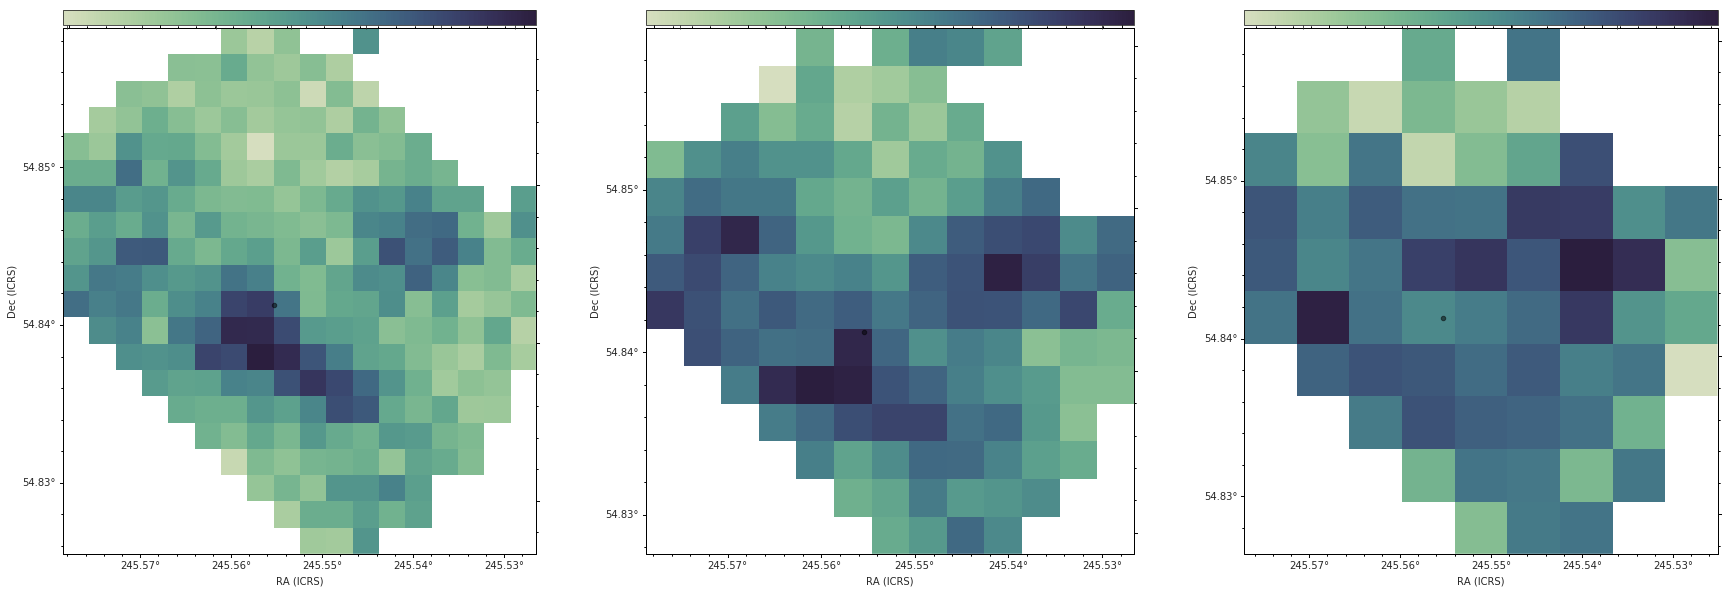

In [72]:
figs,fig=xidplus.plot_map(priors)

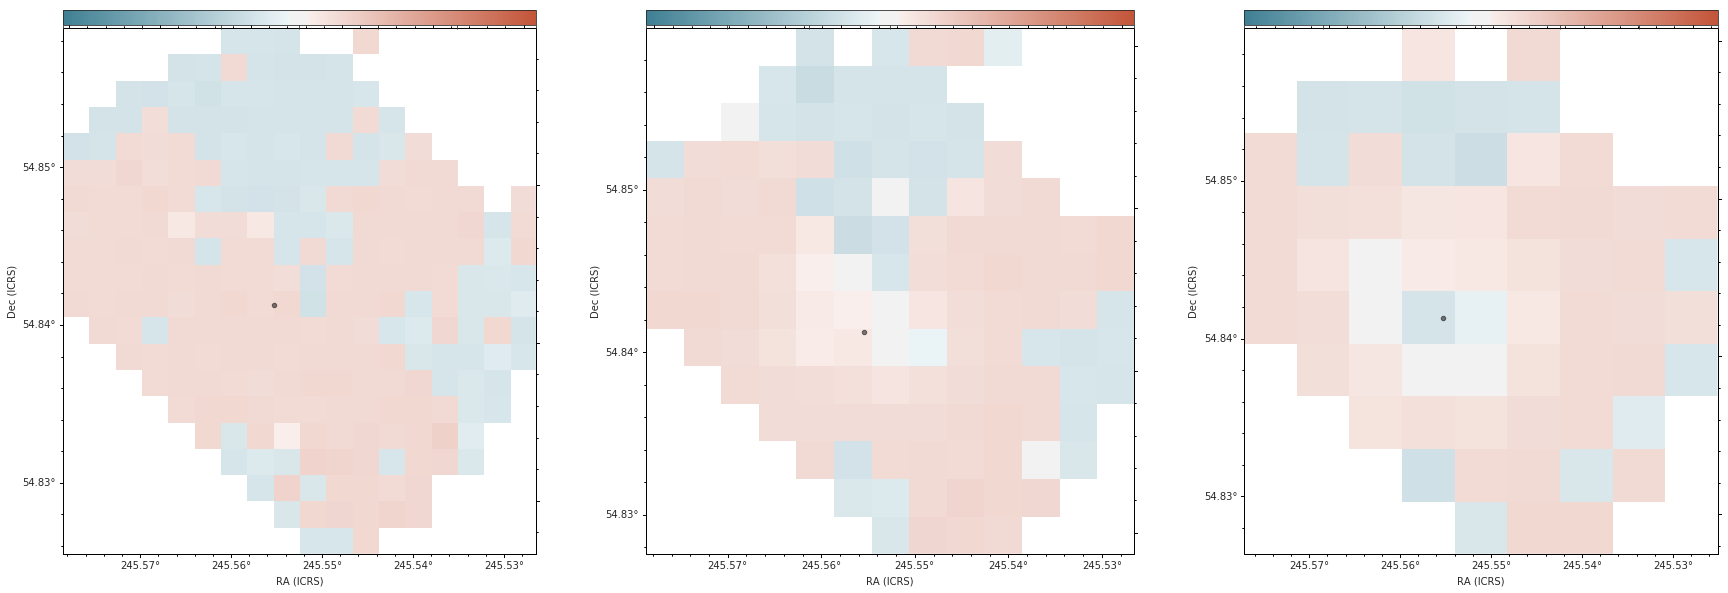

In [73]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [138]:
import xidplus.catalogue as cat
SPIRE_cat=cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])

In [139]:
SPIRE_cat = Table.read(SPIRE_cat)

In [140]:
mask = SPIRE_cat['HELP_ID']=='lofar'
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [9]:
len(lofar)

32833